# Machine Learning estimation for std properties

Based on the Molar Mass, State of Matter, Charge, number of Elements, and entropy of elements, we now create machine learning models to predict the standard free Gibbs energy of formation, enthalpy, entropy, and heat capacities.

## Required dependencies

In [1]:
import os
# Should be set before importing numpy
# This setup decreased the run times by near 3 times
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import multiprocessing as mp
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import random
from tqdm.auto import tqdm

import sklearn
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import Callback, EpochScoring

from pathlib import Path

DATA_PATH = Path(os.environ.get("DATAPATH"))
sklearn.set_config(transform_output="pandas")

pio.renderers.default = "png"

# For reproducibility's sake
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Set the number of threads to be used by `PyTorch`:

In [2]:
available_cpus = mp.cpu_count()
parallel_jobs = available_cpus - 2 if available_cpus > 2 else 1
torch.set_num_threads(parallel_jobs)

Check if PyTorch can use CUDA:

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Read preprocessed data

### Loading

In [4]:
df_nist_stdprops = pd.read_csv(DATA_PATH / "NBS_Tables_preprocessed.csv", index_col=0)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0
...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0


### Extending with Se (entropy of the elements of the chemical species) and Num of Elements

Reading elements data:

In [5]:
df_nist_elements = pd.read_csv(DATA_PATH / "nist_elements.csv", index_col=0)

df_nist_elements

,element,state,S0
0,O,g,102.569
1,H,g,65.342
2,He,g,126.150
3,Ne,g,146.328
4,Ar,g,154.843
...,...,...,...
123,Li,cr,29.120
124,Na,cr,51.210
125,K,cr,64.180
126,Rb,cr,76.780


In [6]:
def parse_chemical_formula(formula: str) -> dict[str, int]:
    """
    Convenient function to parser and get the amount of elements in
    chemical species formulas.
    """
    import re
    from collections import defaultdict
    
    # Function to parse a molecule or sub-molecule
    def parse_molecule(molecule, multiplier=1):
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', molecule)
        for element, count in elements:
            count = int(count) if count else 1
            element_counts[element] += count * multiplier

    # Remove HTML charge notations
    formula = re.sub(r'<[^>]+>', '', formula)

    # Split the formula into molecules and process each part
    element_counts = defaultdict(int)
    molecules = formula.split('·')
    
    for molecule in molecules:
        # Handle molecules with and without parentheses
        if '(' in molecule:
            while '(' in molecule:
                # Find and replace the innermost parenthetical expression
                sub_molecule, sub_multiplier = re.search(r'\(([A-Za-z0-9]+)\)(\d*)', molecule).groups()
                sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
                molecule = re.sub(r'\(([A-Za-z0-9]+)\)(\d*)', '', molecule, 1)
                parse_molecule(sub_molecule, sub_multiplier)
        
        # Handle preffix-like multiplier
        else:
            sub_multiplier, sub_molecule = re.search(r'(\d*)([A-Za-z0-9]+)', molecule).groups()
            sub_multiplier = int(sub_multiplier) if sub_multiplier else 1
            molecule = re.sub(r'(\d*)([A-Za-z0-9]+)', '', molecule, 1)
            parse_molecule(sub_molecule, sub_multiplier)
            
        # Process the remaining parts of the molecule
        parse_molecule(molecule)

    return dict(element_counts)

In [7]:
Se_species = []
n_elements_in_species = []
for index, row in df_nist_stdprops.iterrows():
    species_formula = row["Formula"]
    elements_in_species = parse_chemical_formula(species_formula)
    
    elements_S0 = 0.0
    n_elements = 0.0
    try:
        for element, count in elements_in_species.items():
            df_element = df_nist_elements.loc[df_nist_elements['element'] == element]
            elements_S0 += df_element['S0'].values[0] * count
            n_elements += count

    except IndexError:
        print(f"Skipping species {species_formula}: element {element} is lacking")
        elements_S0 = np.nan
        n_elements = np.nan
    
    Se_species.append(elements_S0)
    n_elements_in_species.append(n_elements)
    
df_nist_stdprops["Se"] = Se_species
df_nist_stdprops["Num Elements"] = n_elements_in_species

Skipping species D: element D is lacking
Skipping species D2: element D is lacking
Skipping species HD: element D is lacking
Skipping species OD: element D is lacking
Skipping species D2O: element D is lacking
Skipping species D2O: element D is lacking
Skipping species HDO: element D is lacking
Skipping species YD2: element D is lacking
Skipping species YD3: element D is lacking
Skipping species LiD: element D is lacking
Skipping species LiD: element D is lacking
Skipping species KD: element D is lacking


In [8]:
df_nist_stdprops.head(20)

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
5,D,g,2.0141,221.673,206.506,123.349,20.786,0.0,NaN,NaN
6,H2,g,2.0160,0.000,0.000,130.684,28.824,0.0,130.684,2.0
7,D2,g,4.0282,0.000,0.000,144.960,29.196,0.0,NaN,NaN
8,HD,g,3.0221,0.318,-1.464,143.801,29.196,0.0,NaN,NaN
9,OH,g,17.0074,38.950,34.230,183.745,29.886,0.0,167.911,2.0


In [9]:
df_nist_stdprops.dropna(inplace=True)

df_nist_stdprops

,Formula,State,Molar Mass,deltaH0,deltaG0,S0,Cp,Charge,Se,Num Elements
0,O,g,15.9994,249.170,231.731,161.055,21.912,0.0,102.569,1.0
1,O2,g,31.9988,0.000,0.000,205.138,29.355,0.0,205.138,2.0
2,O3,g,47.9982,142.700,163.200,238.930,39.200,0.0,307.707,3.0
3,H,g,1.0080,217.965,203.247,114.713,20.784,0.0,65.342,1.0
4,H<sup>+</sup>,ao,1.0080,0.000,0.000,0.000,0.000,1.0,65.342,1.0
...,...,...,...,...,...,...,...,...,...,...
1515,CsBO2,g,175.7152,-703.300,-708.800,314.410,59.410,0.0,296.228,4.0
1516,CsAl(SO4)2·12H2O,cr,568.1949,-6094.800,-5167.400,686.090,614.600,0.0,3796.748,48.0
1517,CsCuCl3,cr,302.8044,-698.700,-627.100,213.380,127.820,0.0,452.979,5.0
1518,Cs2Cr2O7,cr,481.7986,-2088.820,-1908.170,330.080,231.540,0.0,935.983,11.0


## Organizing the data

Separating features and targets:

In [10]:
features_columns = ["Molar Mass", "State", "Charge", "Se", "Num Elements"]
target_columns = ["deltaH0", "deltaG0", "S0", "Cp"]

X = df_nist_stdprops[features_columns]
y = df_nist_stdprops[target_columns]

### Encoding the State of Matter feature

Let's put together state of matter with few occurences (unsure if this is a good approach):

In [11]:
X["State"].value_counts()

State
cr     708
g      523
ai      99
l       74
ao      39
cr2     27
g2      14
cr3      8
l2       7
am       4
g3       2
cr4      2
l3       1
Name: count, dtype: int64

In [12]:
state_renamings = {
    "g2": "g",
    "cr3": "cr",
    "l2": "l",
    "g3": "g",
    "cr4": "cr",
    "l3": "l",
}
X.replace(state_renamings, inplace=True)

/tmp/ipykernel_18234/196545353.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X[["State"]])

encoder_categories = list(encoder.categories_[0])

encoder_categories

['ai', 'am', 'ao', 'cr', 'cr2', 'g', 'l']

In [14]:
X_state_encoded = encoder.transform(X[["State"]])

X_state_encoded

,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1515,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1516,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1517,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1518,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
X_encoded = pd.concat([X, X_state_encoded], axis=1)
X_encoded.drop(columns=["State"], inplace=True)

X_encoded

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
0,15.9994,0.0,102.569,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,31.9988,0.0,205.138,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,47.9982,0.0,307.707,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0080,0.0,65.342,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0080,1.0,65.342,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1515,175.7152,0.0,296.228,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1516,568.1949,0.0,3796.748,48.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1517,302.8044,0.0,452.979,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1518,481.7986,0.0,935.983,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Splitting the data

In [16]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=test_size)

In [17]:
X_train

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
541,65.3700,0.0,41.630,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1070,24.3120,0.0,32.680,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
820,61.9067,0.0,126.435,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1247,23.9484,0.0,197.031,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,168.3584,0.0,196.763,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1139,1004.6432,0.0,3458.218,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1305,76.0280,0.0,685.627,9.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
869,397.9382,0.0,409.627,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1471,124.4726,0.0,344.902,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
y_train

,deltaH0,deltaG0,S0,Cp
541,0.000,0.000,41.630,25.400
1070,147.700,113.100,148.650,20.786
820,-338.100,-309.600,30.250,37.070
1247,-508.480,-450.580,2.800,-79.900
1500,-240.200,-257.800,255.960,36.940
...,...,...,...,...
1139,-13477.000,-12677.000,780.700,769.900
1305,-1019.076,-873.091,195.979,239.410
869,-1878.200,-1789.000,109.960,101.750
1471,-922.600,-855.600,120.080,79.370


## Data scaling

In [19]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_rescaled = scaler.transform(X_train)  
X_test_rescaled = scaler.transform(X_test)  

In [20]:
X_train_rescaled

,Molar Mass,Charge,Se,Num Elements,State_ai,State_am,State_ao,State_cr,State_cr2,State_g,State_l
541,-0.708488,-0.073791,-0.664733,-0.675371,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1070,-0.980178,-0.073791,-0.680533,-0.675371,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,1.338877,-0.242876
820,-0.731406,-0.073791,-0.515023,-0.536110,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1247,-0.982584,-0.073791,-0.390396,-0.396850,3.699772,-0.059576,-0.170638,-0.937410,-0.137546,-0.746894,-0.242876
1500,-0.026991,-0.073791,-0.390870,-0.536110,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,1.338877,-0.242876
...,...,...,...,...,...,...,...,...,...,...,...
1139,5.506894,-0.073791,5.366723,5.312836,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1305,-0.637962,-0.073791,0.472144,0.438714,-0.270287,-0.059576,-0.170638,-0.937410,-0.137546,-0.746894,4.117327
869,1.492191,-0.073791,-0.015091,-0.118328,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876
1471,-0.317393,-0.073791,-0.129353,-0.257589,-0.270287,-0.059576,-0.170638,1.066769,-0.137546,-0.746894,-0.242876


## Build the machine learning model (Neural Network, in this case)

### MLP model setup with `skorch`

In [21]:
num_features = int(X_train_rescaled.shape[1])
num_targets = int(y_train.shape[1])


class NetArchitecture(nn.Module):
    """
    The neural net achitecture setup.
    """
    def __init__(self):
        super(NetArchitecture, self).__init__()
        self.input_layer = nn.Linear(num_features, 20)
        self.hidden_layer1 = nn.Linear(20, 30)
        self.hidden_layer2 = nn.Linear(30, 20)
        self.hidden_layer3 = nn.Linear(20, 10)
        self.output_layer = nn.Linear(10, num_targets)
        
        # Use the same initial weights and biases as tensorflow
        self.initialize_weights_and_biases()

    def initialize_weights_and_biases(self):
        '''
        Convenient automatic initialization of weights and biases.
        
        This sets the same initialization used in TensorFlow.
        Good to compare the performance.
        '''
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Initialize weights with Xavier uniform (Glorot uniform)
                nn.init.xavier_uniform_(module.weight)
                # Initialize bias to zeros
                nn.init.zeros_(module.bias)
                
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = torch.relu(self.hidden_layer3(x))
        x = self.output_layer(x)
        return x


class CustomNetThermodynamicInformed(NeuralNetRegressor):
    def __init__(
        self, *args, lambda1=1e-1, negative_loss=False, use_r2_score=False, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
        self.negative_loss = negative_loss
        self.use_r2_score = use_r2_score

    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss = self.criterion_(y_pred, y_true)
        
        # Extract the actual data from the Skorch Dataset
        if isinstance(X, skorch.dataset.Dataset):
            X = X.X  # Access the underlying numpy array
        
        dG0 = torch.mul(y_pred[:, 1], 1000).float()
        dH0 = torch.mul(y_pred[:, 0], 1000).float()
        T = 298.15
        dS0 = torch.mul(y_pred[:, 2], T).float()
        
        # Undo scaling applied to Se values to properly compute the residuals
        X_as_numpy = scaler.inverse_transform(X)
        Se_torch_tensor = torch.from_numpy(X_as_numpy[:, 2]).float()
        dSe = torch.mul(Se_torch_tensor, T)
        
        # Compute the GHS residual
        GHS_residual_left_hand_side = dG0
        GHS_residual_right_hand_side = dH0 - (dS0 - dSe)
        GHS_residual = GHS_residual_left_hand_side - GHS_residual_right_hand_side
        custom_term = torch.norm(GHS_residual, p=2) / y_pred.size(0)
        
        loss += self.lambda1 * custom_term
        return loss
    
    def score(self, X, y):
        loss = np.nan
        self.check_is_fitted()
        X = self.get_dataset(X)
        y = torch.as_tensor(y, device=self.device)
        y_pred = self.predict(X)
        
        if self.use_r2_score:
            loss = r2_score(y, y_pred)
        else:
            y_pred = torch.as_tensor(y_pred, device=self.device)

            # Compute the custom loss
            loss = self.get_loss(y_pred, y, X=X, training=False)
            loss = -loss.item() if self.negative_loss else loss.item()
            
        return loss


Convenient callback functions:

* R2 score callback:

In [22]:
r2_scoring = EpochScoring(
    scoring='r2', 
    lower_is_better=False,
    on_train=False,
    name='valid_r2'
)

* Progress bar callback:

In [23]:
class TqdmCallback(Callback):
    def on_train_begin(self, net, X, y, **kwargs):
        self.pbar = tqdm(total=net.max_epochs)

    def on_epoch_end(self, net, **kwargs):
        self.pbar.update(1)
        epoch = net.history[-1]
        self.pbar.set_postfix({
            'loss': epoch['train_loss'],
            'valid_r2': epoch['valid_r2'] if 'valid_r2' in epoch else 'N/A'
        })

    def on_train_end(self, net, X, y, **kwargs):
        self.pbar.close()

* Early stopping callback:

In [24]:
max_epochs = 20000
rel_error_stop_criterion = 1e-8
min_percentage_of_num_epochs = 0.1
early_stopping = skorch.callbacks.EarlyStopping(
    patience=int(min_percentage_of_num_epochs * max_epochs), 
    threshold=rel_error_stop_criterion
)

### Hyper-parameter optimization

Before run a full NN models, let's find the best parameters to configure our NN model beforehand.

* Convenient custom score considering the implemented custom loss function in the MLP:

In [25]:
def custom_loss_scorer(net, X, y):
    # Predict using the provided net
    y_pred = net.predict(X)

    # Convert y and y_pred to PyTorch tensors
    y_true_tensor = torch.as_tensor(y, dtype=torch.float32)
    y_pred_tensor = torch.as_tensor(y_pred, dtype=torch.float32)

    # Compute the custom loss using the net's get_loss method
    # Assuming X is already a numpy array and not a Skorch Dataset here
    loss = net.get_loss(y_pred_tensor, y_true_tensor, X=X, training=False)

    # Return the negative loss since lower is better
    return -loss.item()

* The reduced NN model:

In [26]:
max_epochs_gs = 3000
rel_error_stop_criterion_gs = 1e-6
min_percentage_of_num_epochs_gs = 0.1
early_stopping_gs = skorch.callbacks.EarlyStopping(
    patience=int(min_percentage_of_num_epochs_gs * max_epochs_gs), 
    threshold=rel_error_stop_criterion_gs
)

lambda1 = 1e1
model_gs = NetArchitecture()
net_gs_fit = CustomNetThermodynamicInformed(
    module=model_gs,
    criterion=nn.MSELoss(),
    lambda1=lambda1,
    # The sklearn hyperparam optimimization is a maximization of the score.
    # Thus, since the loss is a MSE, we need to use loss = -loss.
    # This is only need in the hyperparam optimization, pytorch works
    # with the minimization of the loss function.
    negative_loss=True,
    use_r2_score=True,
    max_epochs=max_epochs_gs,
    lr=1e-2,
    batch_size=X_train_rescaled.shape[0],
    optimizer=torch.optim.Adam,
    callbacks=[early_stopping_gs],
    device='cpu',
    verbose=False
)

* Setting the Randomized Search Cross-Validation to explore the parameters in a 4-folds setting:

In [27]:
ss_generator = ShuffleSplit(n_splits=4, test_size=test_size, random_state=1)

In [28]:
lr_values = np.random.uniform(1e-5, 2e-1, 30).tolist()
# lambda1_values = np.random.uniform(0.001, 5e1, 30).tolist()  # not a hyper-parameter!
params = {
    'lr': lr_values,
    # 'lambda1': lambda1_values,  # in fact, this is not a hyper-parameter since it changes the fobj
}

gs = RandomizedSearchCV(
    net_gs_fit, 
    params, 
    scoring={"r2": make_scorer(r2_score), "Constrained Loss": custom_loss_scorer},
    refit="Constrained Loss",
    cv=ss_generator, 
    n_iter=10, 
    random_state=42, 
    verbose=3
)

* Search the best parameters using the reduced model:

In [29]:
X_full_rescaled = scaler.transform(X_encoded)

gs.fit(
    X_full_rescaled.to_numpy().astype(np.float32),
    y.to_numpy().astype(np.float32)
)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END lr=0.007820566098744144; Constrained Loss: (test=-86764.195) r2: (test=0.834) total time=  22.1s
[CV 2/4] END lr=0.007820566098744144; Constrained Loss: (test=-84692.875) r2: (test=0.855) total time=  15.6s
[CV 3/4] END lr=0.007820566098744144; Constrained Loss: (test=-73975.781) r2: (test=0.768) total time=  14.9s
[CV 4/4] END lr=0.007820566098744144; Constrained Loss: (test=-122904.891) r2: (test=0.617) total time=  14.8s
[CV 1/4] END lr=0.13409679736057867; Constrained Loss: (test=-110452.375) r2: (test=0.666) total time=   7.4s
[CV 2/4] END lr=0.13409679736057867; Constrained Loss: (test=-129326.211) r2: (test=0.819) total time=  18.4s
[CV 3/4] END lr=0.13409679736057867; Constrained Loss: (test=-134110.766) r2: (test=0.560) total time=   6.2s
[CV 4/4] END lr=0.13409679736057867; Constrained Loss: (test=-323310.844) r2: (test=0.296) total time=   5.7s
[CV 1/4] END lr=0.13846759990770613; Constrained Loss: (te

RandomizedSearchCV(cv=ShuffleSplit(n_splits=4, random_state=1, test_size=0.25, train_size=None),
                   estimator=<class '__main__.CustomNetThermodynamicInformed'>[uninitialized](
  module=NetArchitecture(
    (input_layer): Linear(in_features=11, out_features=20, bias=True)
    (hidden_layer1): Linear(in_features=20, out_features=30, bias=True)
    (hidden_layer2): Linear(in_features...
                                               0.16015090628942058,
                                               0.19365263252812231,
                                               0.06269170139006697,
                                               0.13846759990770613,
                                               0.17527906656768472,
                                               0.17892238663413443,
                                               0.017017991831841883,
                                               0.007820566098744144,
                                               0.03397438560871814,
                                               0.17562971926084833]},
                   random_state=42, refit='Constrained Loss',
                   scoring={'Constrained Loss': <function custom_loss_scorer at 0x7f53ec5e62a0>,
                            'r2': make_scorer(r2_score)},
                   verbose=3)

In [30]:
df_parameter_search = pd.DataFrame.from_dict(gs.cv_results_)

df_parameter_search

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_Constrained Loss,split1_test_Constrained Loss,split2_test_Constrained Loss,split3_test_Constrained Loss,mean_test_Constrained Loss,std_test_Constrained Loss,rank_test_Constrained Loss
0,16.834819,3.035968,0.007878,0.000295,0.007821,{'lr': 0.007820566098744144},0.833746,0.855356,0.768423,0.616603,0.768532,0.093373,1,-86764.195312,-84692.875000,-73975.781250,-122904.890625,-92084.435547,18444.266963,1
1,9.409223,5.230581,0.008477,0.001094,0.134097,{'lr': 0.13409679736057867},0.666394,0.819464,0.560069,0.296345,0.585568,0.190748,10,-110452.375000,-129326.210938,-134110.765625,-323310.843750,-174300.048828,86484.922148,10
2,13.744716,5.114203,0.007318,0.000512,0.138468,{'lr': 0.13846759990770613},0.728781,0.826927,0.779872,0.262360,0.649485,0.226186,4,-103207.539062,-137787.671875,-89263.562500,-251914.375000,-145543.287109,63903.600977,7
3,9.753114,3.865947,0.007327,0.000489,0.111742,{'lr': 0.11174237879086588},0.647289,0.892550,0.752318,0.153645,0.611451,0.278267,9,-93456.562500,-84227.234375,-94989.210938,-267800.968750,-135118.494141,76714.788841,5
4,8.930350,1.943632,0.007082,0.000183,0.07936,{'lr': 0.07935952717139168},0.698657,0.771361,0.543278,0.516664,0.632490,0.106110,7,-88790.578125,-129560.539062,-150261.531250,-113620.687500,-120558.333984,22475.769593,2
5,12.265905,6.253999,0.007159,0.000070,0.107768,{'lr': 0.10776795863333136},0.662070,0.850739,0.572051,0.505234,0.647523,0.129856,5,-131238.796875,-87760.718750,-142795.796875,-148441.968750,-127559.320312,23799.697781,4
6,8.268954,1.971729,0.007229,0.000357,0.033974,{'lr': 0.03397438560871814},0.740852,0.835714,0.523381,0.445632,0.636395,0.157957,6,-97089.789062,-128787.796875,-137315.484375,-260015.843750,-155802.228516,62006.385503,9
7,11.471935,6.309212,0.007660,0.000655,0.175279,{'lr': 0.17527906656768472},0.629914,0.771989,0.769806,0.274237,0.611487,0.203041,8,-120200.820312,-108551.875000,-89938.890625,-252658.359375,-142837.486328,64317.197110,6
8,15.704662,6.517911,0.008018,0.000830,0.040898,{'lr': 0.040898405423806176},0.795710,0.786707,0.548494,0.659041,0.697488,0.101593,3,-128937.773438,-153409.296875,-140794.640625,-167595.078125,-147684.197266,14388.487926,8
9,12.615407,6.003734,0.008121,0.000678,0.08341,{'lr': 0.08341023072046777},0.628952,0.860297,0.579550,0.723118,0.697979,0.106969,2,-122576.937500,-117512.039062,-127837.281250,-132923.609375,-125212.466797,5757.472812,3


* Collecting the results:

In [31]:
# best_lambda1 = gs.best_params_['lambda1']  # not a hyper-parameter!
best_lr = gs.best_params_['lr']

# print(f"Best lambda1 = {best_lambda1}\t Best lr = {best_lr}")
print(f"Best lr = {best_lr}")

Best lr = 0.007820566098744144


### Setting the complete NN model:

Initialize the NN with skorch:

In [32]:
net = CustomNetThermodynamicInformed(
    module=NetArchitecture,
    criterion=nn.MSELoss(),
    lambda1=lambda1,
    max_epochs=max_epochs,
    lr=best_lr,
    batch_size=X_train_rescaled.shape[0],
    optimizer=torch.optim.Adam,
    callbacks=[r2_scoring, TqdmCallback(), early_stopping],
    # device='cuda' if torch.cuda.is_available() else 'cpu',
    device='cpu',
    verbose=False
)

In [33]:
X_torch = torch.from_numpy(X_train_rescaled.to_numpy()).float()
y_torch = torch.from_numpy(y_train.to_numpy()).float()

### Training/testing the model

Perform training:

In [34]:
net.fit(X_torch, y_torch)

  0%|          | 0/20000 [00:00<?, ?it/s]

<class '__main__.CustomNetThermodynamicInformed'>[initialized](
  module_=NetArchitecture(
    (input_layer): Linear(in_features=11, out_features=20, bias=True)
    (hidden_layer1): Linear(in_features=20, out_features=30, bias=True)
    (hidden_layer2): Linear(in_features=30, out_features=20, bias=True)
    (hidden_layer3): Linear(in_features=20, out_features=10, bias=True)
    (output_layer): Linear(in_features=10, out_features=4, bias=True)
  ),
)

Run predictions:

In [35]:
X_test_torch = torch.from_numpy(X_test_rescaled.to_numpy()).float()
y_predict = net.predict(X_test_torch)

In [36]:
dict_y_predict = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict[target] = y_predict[:, id_target]
    
df_y_predict = pd.DataFrame.from_dict(dict_y_predict)

df_y_predict

,deltaH0,deltaG0,S0,Cp
0,-116.072151,-61.856926,294.594238,84.070709
1,-1893.109619,-1778.153076,111.800858,111.881226
2,-3.573109,-30.530701,205.991470,55.745239
3,-301.313629,-274.102448,69.547508,62.962341
4,-678.035217,-694.784180,317.276550,47.635956
...,...,...,...,...
372,-655.465515,-626.321655,282.259949,65.409851
373,-3146.597656,-2991.389404,181.451584,184.790710
374,20.733070,19.053005,36.969147,10.663681
375,-352.068512,-272.515839,82.550377,90.530243


Check the score:

In [37]:
r2_score(y_test, y_predict)

0.7719795988522506

### Evaluate the loss function evolution through the epochs

In [38]:
history = net.history
loss_history = history[:, 'valid_loss']
r2_history = history[:, 'valid_r2']

df_loss_history = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_history) + 1)), 
        "Loss function evaluations": loss_history,
        "R2 score": r2_history
    }
)

df_loss_history

,Epoch,Loss function evaluations,R2 score
0,1,1.172352e+06,-0.794153
1,2,1.172012e+06,-0.793664
2,3,1.171587e+06,-0.793116
3,4,1.171042e+06,-0.792543
4,5,1.170344e+06,-0.791974
...,...,...,...
13773,13774,1.456348e+05,0.799464
13774,13775,1.428174e+05,0.800629
13775,13776,1.461054e+05,0.799593
13776,13777,1.430348e+05,0.800147


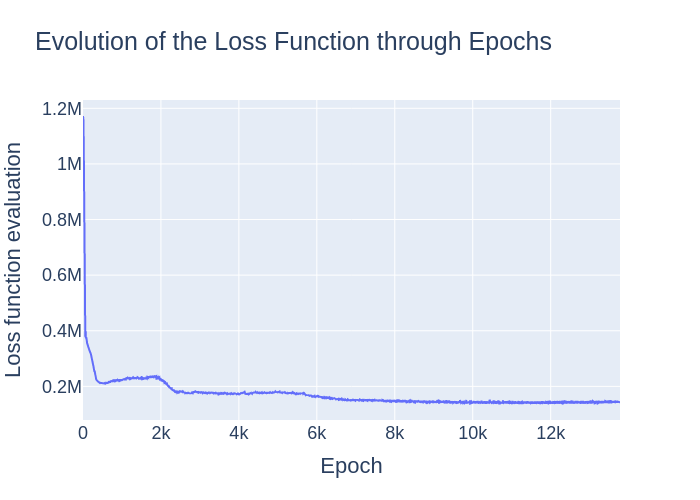

In [39]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history["Epoch"], 
    y=df_loss_history["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)

fig.show()

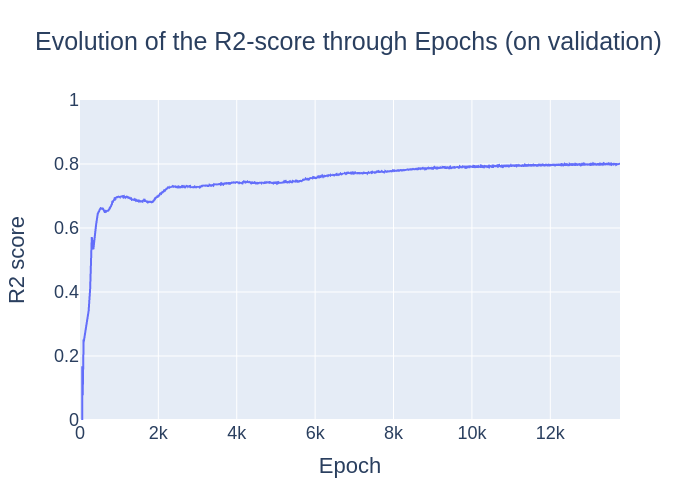

In [40]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history["Epoch"], 
    y=df_loss_history["R2 score"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the R2-score through Epochs (on validation)",
    xaxis_title="Epoch",
    yaxis_title="R2 score",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)
fig.update_yaxes(range=[0.0, 1.0])

fig.show()

### MLP model setup with `skorch`/`pytorch` without thermodynamical constrains

In [41]:
net_unconstrained = NeuralNetRegressor(
    module=NetArchitecture,
    max_epochs=max_epochs,
    lr=best_lr,
    batch_size=X_train_rescaled.shape[0],
    optimizer=torch.optim.Adam,
    callbacks=[r2_scoring, TqdmCallback(), early_stopping],
    # device='cuda' if torch.cuda.is_available() else 'cpu',
    device='cpu',
    verbose=False
)

In [42]:
net_unconstrained.fit(X_torch, y_torch)

  0%|          | 0/20000 [00:00<?, ?it/s]

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=NetArchitecture(
    (input_layer): Linear(in_features=11, out_features=20, bias=True)
    (hidden_layer1): Linear(in_features=20, out_features=30, bias=True)
    (hidden_layer2): Linear(in_features=30, out_features=20, bias=True)
    (hidden_layer3): Linear(in_features=20, out_features=10, bias=True)
    (output_layer): Linear(in_features=10, out_features=4, bias=True)
  ),
)

In [43]:
y_predict_unconstrained = net_unconstrained.predict(X_test_torch)

dict_y_predict_unconstrained = {}
for id_target, target in enumerate(list(y_train.columns)):
    dict_y_predict_unconstrained[target] = y_predict_unconstrained[:, id_target]
    
df_y_predict_unconstrained = pd.DataFrame.from_dict(dict_y_predict_unconstrained)

df_y_predict_unconstrained

,deltaH0,deltaG0,S0,Cp
0,-214.490738,-173.548828,353.666931,97.001732
1,-2150.242188,-2026.942261,105.790421,126.055244
2,60.007366,32.711582,192.130127,39.369461
3,-4.538205,-16.379818,109.347015,40.376534
4,-385.856384,-380.148285,297.195435,63.518761
...,...,...,...,...
372,-759.983398,-728.113586,284.163391,72.047218
373,-2607.422119,-2466.494141,152.568420,148.846359
374,83.366905,79.397713,24.799210,23.670610
375,-271.408478,-240.885284,74.114746,58.293617


In [44]:
r2_score(y_test, y_predict_unconstrained)

0.6242628625672879

In [45]:
history_unconstrained = net_unconstrained.history
loss_history_unconstrained = history_unconstrained[:, 'valid_loss']
r2_history_unconstrained = history_unconstrained[:, 'valid_r2']

df_loss_history_unconstrained = pd.DataFrame.from_dict(
    {
        "Epoch": list(range(1, len(loss_history_unconstrained) + 1)), 
        "Loss function evaluations": loss_history_unconstrained,
        "R2 score": r2_history_unconstrained
    }
)

df_loss_history_unconstrained

,Epoch,Loss function evaluations,R2 score
0,1,1.051467e+06,-0.793242
1,2,1.051348e+06,-0.792938
2,3,1.051221e+06,-0.792484
3,4,1.051069e+06,-0.791808
4,5,1.050882e+06,-0.790942
...,...,...,...
6249,6250,1.236838e+05,0.812315
6250,6251,1.327111e+05,0.805251
6251,6252,1.232682e+05,0.812356
6252,6253,1.316843e+05,0.806010


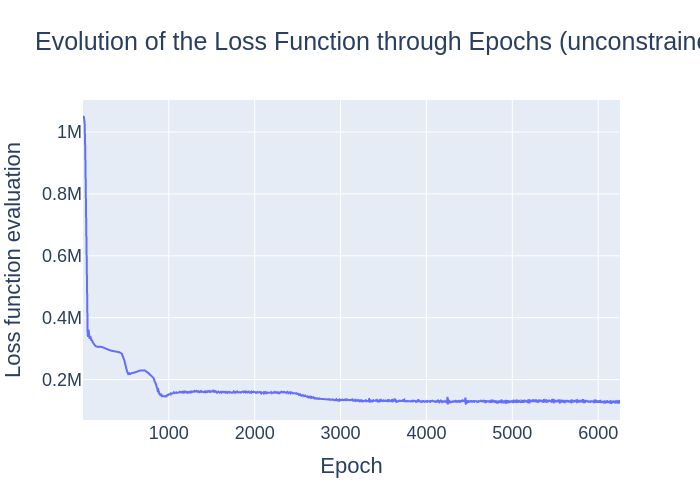

In [46]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history_unconstrained["Epoch"], 
    y=df_loss_history_unconstrained["Loss function evaluations"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the Loss Function through Epochs (unconstrained)",
    xaxis_title="Epoch",
    yaxis_title="Loss function evaluation",
    font=dict(
        size=18,
    ),
)

fig.show()

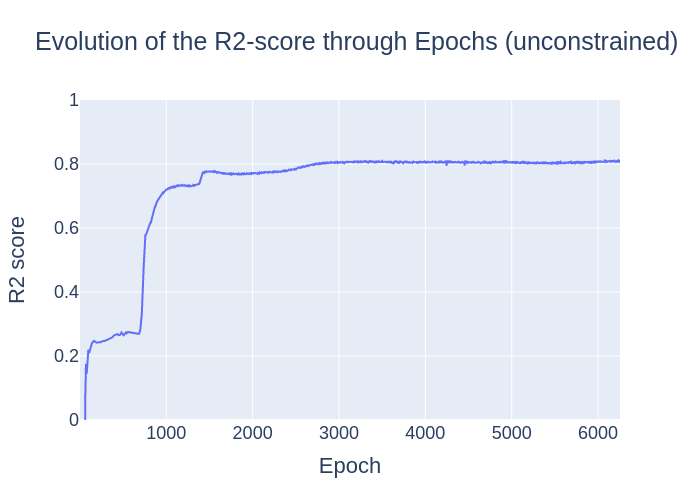

In [47]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_loss_history_unconstrained["Epoch"], 
    y=df_loss_history_unconstrained["R2 score"],
    mode='lines',
)

fig.add_traces([fig1])

fig.update_layout(
    title="Evolution of the R2-score through Epochs (unconstrained)",
    xaxis_title="Epoch",
    yaxis_title="R2 score",
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="right",
    )
)
fig.update_yaxes(range=[0.0, 1.0])

fig.show()

## Assess the results

### Collecting results

* Thermodynamics-Informed:

In [48]:
target_errors = {}

for target_name in list(y_test.columns):
    target_abs_error = np.abs(y_test[target_name].values - df_y_predict[target_name].values)
    target_errors[f"{target_name} abs. error"] = target_abs_error
    
    target_rel_error = target_abs_error / np.abs(df_y_predict[target_name].values)
    target_errors[f"{target_name} rel. error"] = target_rel_error
    
df_target_errors = pd.DataFrame.from_dict(target_errors)
df_target_errors

,deltaH0 abs. error,deltaH0 rel. error,deltaG0 abs. error,deltaG0 rel. error,S0 abs. error,S0 rel. error,Cp abs. error,Cp rel. error
0,210.462151,1.813201,207.956926,3.361902,11.405762,0.038717,0.770709,0.009167
1,433.190381,0.228825,430.546924,0.242132,2.419142,0.021638,8.908774,0.079627
2,490.093109,137.161528,486.610701,15.938406,10.768530,0.052277,25.575239,0.458788
3,132.713629,0.440450,128.102448,0.467352,23.592492,0.339228,0.677659,0.010763
4,212.335217,0.313163,223.284180,0.321372,42.676550,0.134509,3.744044,0.078597
...,...,...,...,...,...,...,...,...
372,399.865515,0.610048,396.891655,0.633687,10.270051,0.036385,1.200149,0.018348
373,1571.947656,0.499571,1555.609404,0.520029,47.151584,0.259858,60.570710,0.327780
374,20.733070,1.000000,19.053005,1.000000,4.120853,0.111467,13.176319,1.235626
375,15.731488,0.044683,22.224161,0.081552,28.029623,0.339546,21.080243,0.232853


* Unconstrained:

In [49]:
target_errors_unconstrained = {}

for target_name in list(y_test.columns):
    target_abs_error = np.abs(y_test[target_name].values - df_y_predict_unconstrained[target_name].values)
    target_errors_unconstrained[f"{target_name} abs. error"] = target_abs_error
    
    target_rel_error = target_abs_error / np.abs(df_y_predict_unconstrained[target_name].values)
    target_errors_unconstrained[f"{target_name} rel. error"] = target_rel_error
    
df_target_errors_unconstrained = pd.DataFrame.from_dict(target_errors_unconstrained)
df_target_errors_unconstrained

,deltaH0 abs. error,deltaH0 rel. error,deltaG0 abs. error,deltaG0 rel. error,S0 abs. error,S0 rel. error,Cp abs. error,Cp rel. error
0,308.880738,1.440066,319.648828,1.841838,47.666931,0.134779,13.701732,0.141252
1,176.057813,0.081878,181.757739,0.089671,8.429579,0.079682,5.265244,0.041769
2,426.512634,7.107671,423.368418,12.942462,24.629873,0.128194,9.199461,0.233670
3,164.061795,36.151251,129.620182,7.913408,16.207015,0.148216,23.263466,0.576163
4,79.843616,0.206926,91.351715,0.240305,22.595435,0.076029,12.138761,0.191105
...,...,...,...,...,...,...,...,...
372,504.383398,0.663677,498.683586,0.684898,8.366609,0.029443,5.437218,0.075467
373,1032.772119,0.396089,1030.714141,0.417886,18.268420,0.119739,24.626359,0.165448
374,83.366905,1.000000,79.397713,1.000000,16.290790,0.656908,0.169390,0.007156
375,96.391522,0.355153,53.854716,0.223570,36.465254,0.492011,11.156383,0.191383


* Assembling the predictions:

In [50]:
target_results = {}

for target_name in list(y_test.columns):
    target_results[f"{target_name} predicted"] = df_y_predict[target_name].values
    target_results[f"{target_name} predicted (unconstrained)"] = df_y_predict_unconstrained[target_name].values
    target_results[f"{target_name} expected"] = y_test[target_name].values
    
df_target_results= pd.DataFrame.from_dict(target_results)
df_target_results

,deltaH0 predicted,deltaH0 predicted (unconstrained),deltaH0 expected,deltaG0 predicted,deltaG0 predicted (unconstrained),deltaG0 expected,S0 predicted,S0 predicted (unconstrained),S0 expected,Cp predicted,Cp predicted (unconstrained),Cp expected
0,-116.072151,-214.490738,94.39,-61.856926,-173.548828,146.10,294.594238,353.666931,306.00,84.070709,97.001732,83.30
1,-1893.109619,-2150.242188,-2326.30,-1778.153076,-2026.942261,-2208.70,111.800858,105.790421,114.22,111.881226,126.055244,120.79
2,-3.573109,60.007366,486.52,-30.530701,32.711582,456.08,205.991470,192.130127,216.76,55.745239,39.369461,30.17
3,-301.313629,-4.538205,-168.60,-274.102448,-16.379818,-146.00,69.547508,109.347015,93.14,62.962341,40.376534,63.64
4,-678.035217,-385.856384,-465.70,-694.784180,-380.148285,-471.50,317.276550,297.195435,274.60,47.635956,63.518761,51.38
...,...,...,...,...,...,...,...,...,...,...,...,...
372,-655.465515,-759.983398,-255.60,-626.321655,-728.113586,-229.43,282.259949,284.163391,292.53,65.409851,72.047218,66.61
373,-3146.597656,-2607.422119,-1574.65,-2991.389404,-2466.494141,-1435.78,181.451584,152.568420,134.30,184.790710,148.846359,124.22
374,20.733070,83.366905,0.00,19.053005,79.397713,0.00,36.969147,24.799210,41.09,10.663681,23.670610,23.84
375,-352.068512,-271.408478,-367.80,-272.515839,-240.885284,-294.74,82.550377,74.114746,110.58,90.530243,58.293617,69.45


### Check `deltaH0` results

Against Molar Mass:

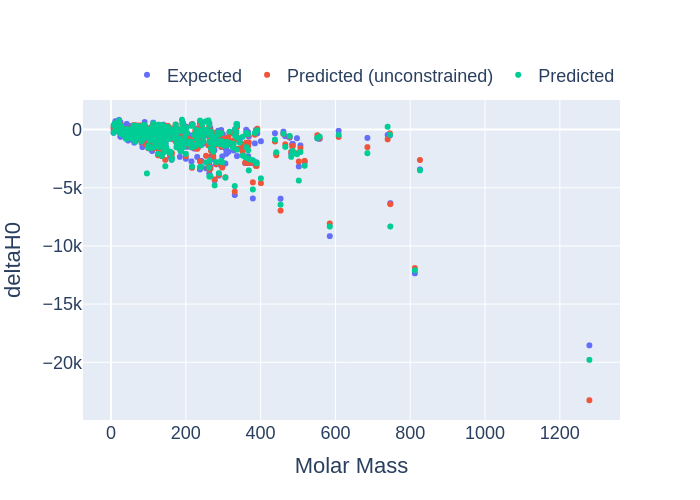

In [51]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaH0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaH0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Against Expected results:

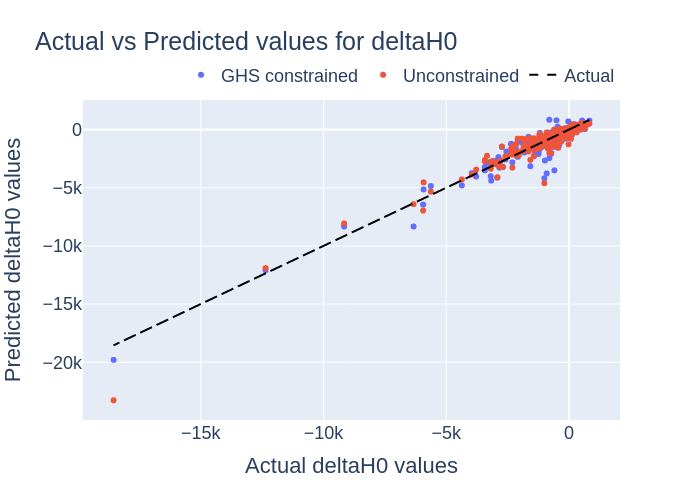

In [52]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["deltaH0 expected"], 
    y=df_target_results["deltaH0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for deltaH0",
    xaxis_title="Actual deltaH0 values",
    yaxis_title="Predicted deltaH0 values",
    showlegend=True,
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

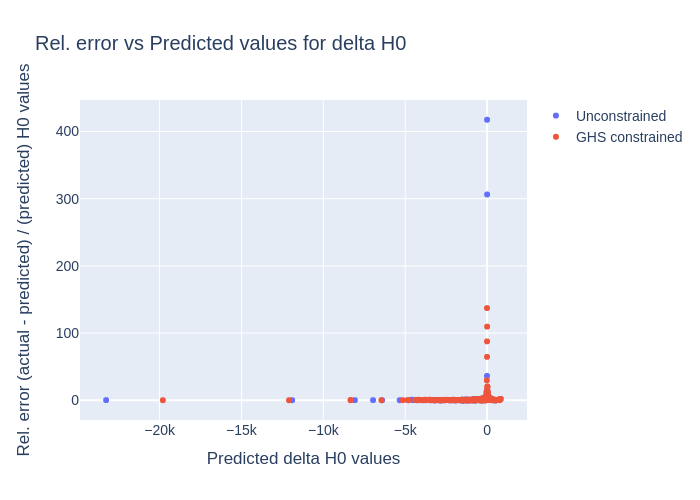

In [53]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaH0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["deltaH0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaH0 predicted"], 
    y=df_target_errors["deltaH0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for delta H0",
    xaxis_title="Predicted delta H0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) H0 values",
    showlegend=True,
    font=dict(
        size=14,
    )
)

fig.show()

`deltaH0` residuals distribution:

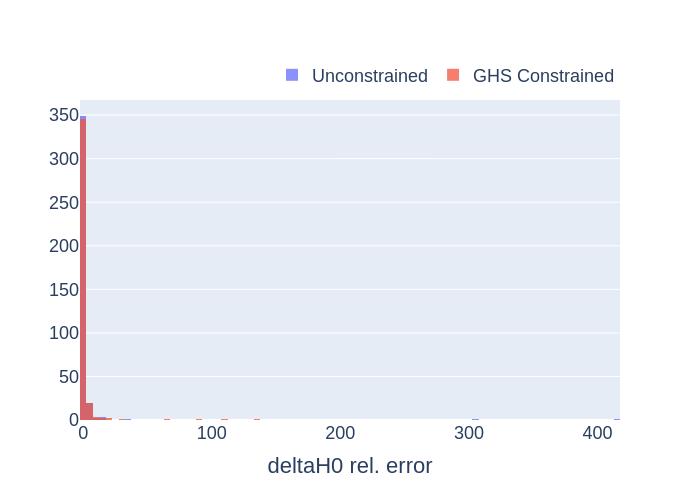

In [54]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["deltaH0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["deltaH0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="deltaH0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Checking `deltaG0` results

Against molar mass:

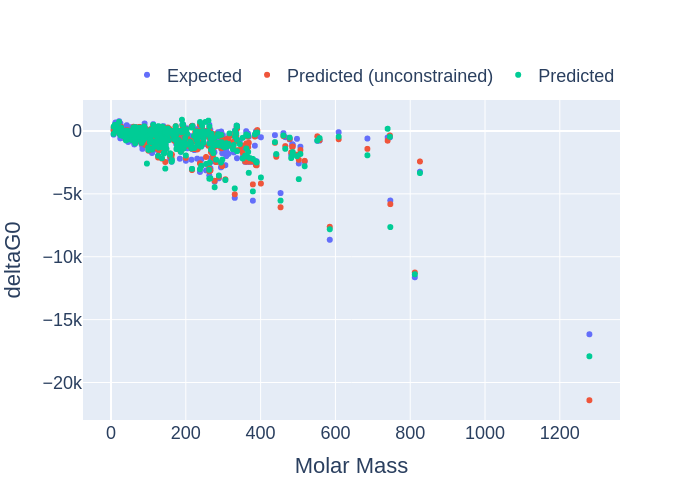

In [55]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["deltaG0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="deltaG0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Against Expected results:

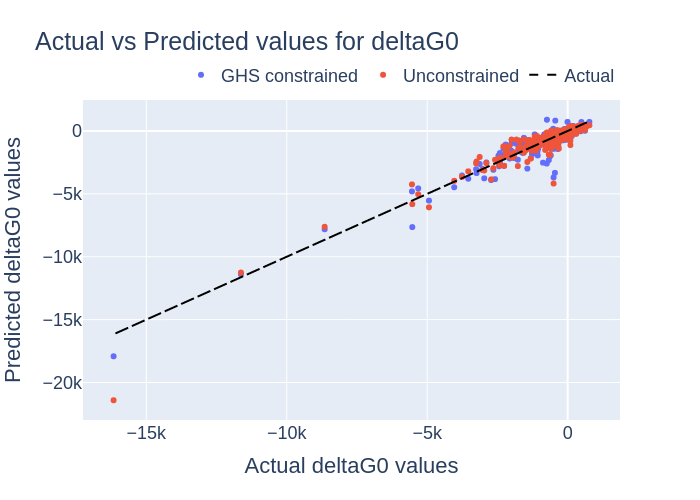

In [56]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["deltaG0 expected"], 
    y=df_target_results["deltaG0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for deltaG0",
    xaxis_title="Actual deltaG0 values",
    yaxis_title="Predicted deltaG0 values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

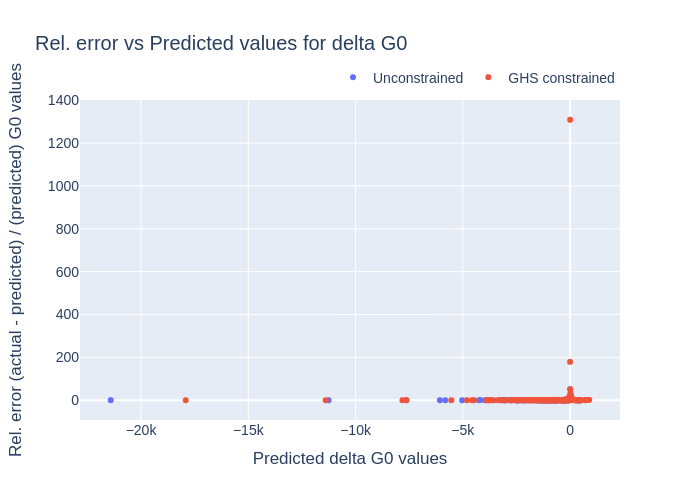

In [57]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["deltaG0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["deltaG0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["deltaG0 predicted"], 
    y=df_target_errors["deltaG0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for delta G0",
    xaxis_title="Predicted delta G0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) G0 values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`deltaG0` residuals distribution:

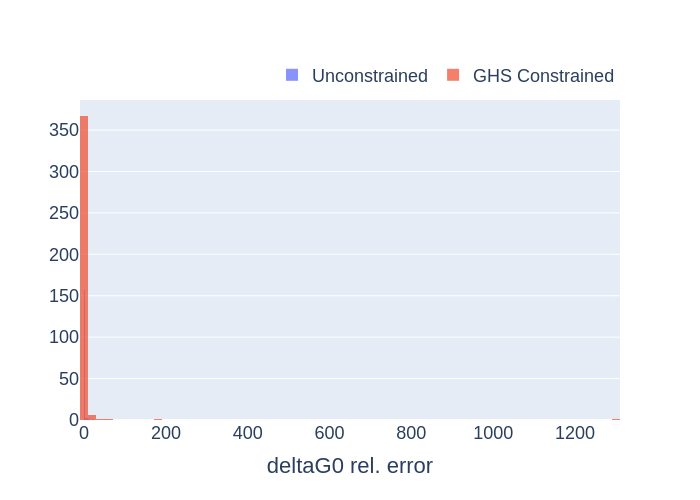

In [58]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["deltaG0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["deltaG0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="deltaG0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Checking `S0` results

Checking against Molar Mass:

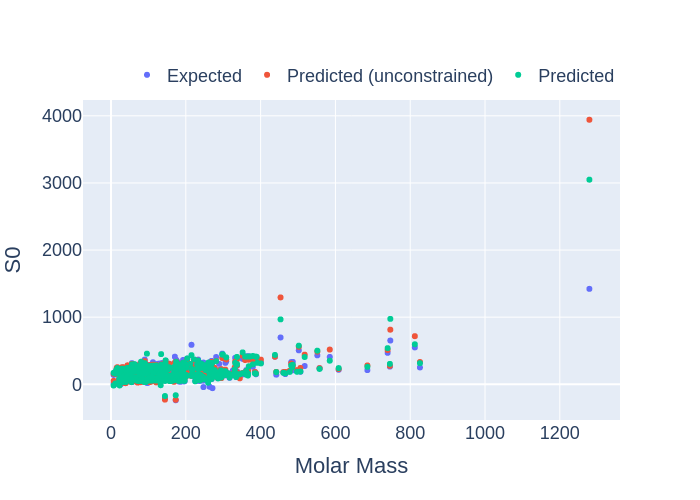

In [59]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["S0 predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="S0",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Checking against expected results:

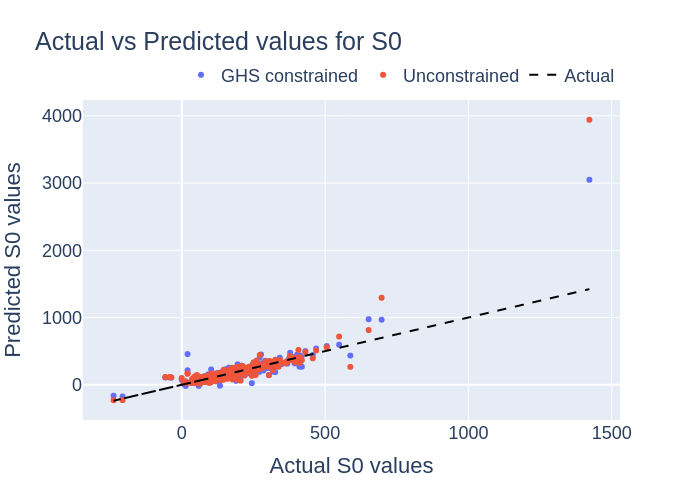

In [60]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["S0 expected"], 
    y=df_target_results["S0 expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for S0",
    xaxis_title="Actual S0 values",
    yaxis_title="Predicted S0 values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

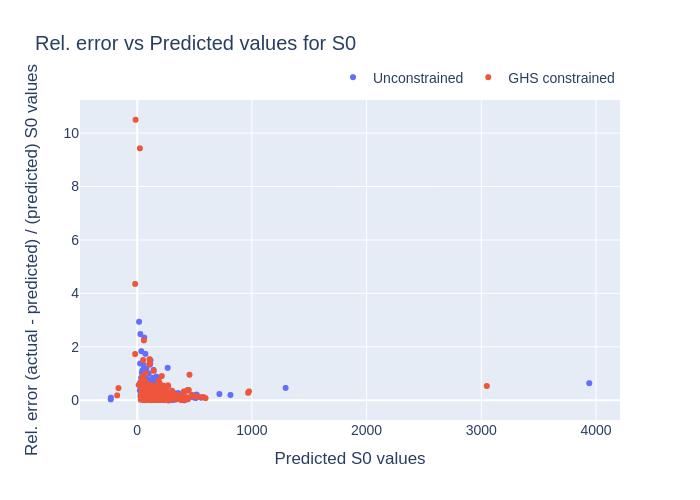

In [61]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["S0 predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["S0 rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["S0 predicted"], 
    y=df_target_errors["S0 rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for S0",
    xaxis_title="Predicted S0 values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) S0 values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`S0` residuals distribution:

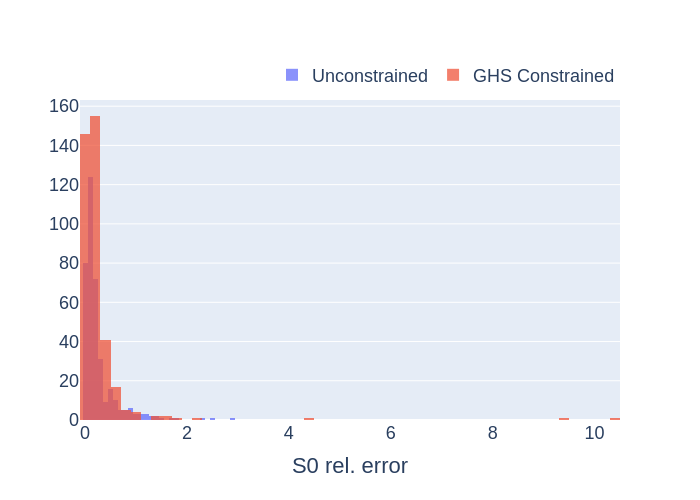

In [62]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["S0 rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["S0 rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="S0 rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Check `Cp` results

Checking against molar mass:

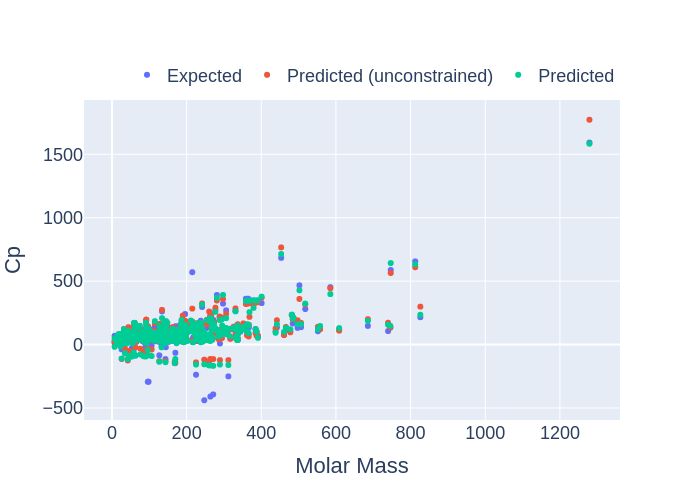

In [63]:
fig = go.Figure()

fig_expected = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp expected"],
    mode='markers',
    name='Expected'
)

fig_predicted = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp predicted"],
    mode='markers',
    name='Predicted'
)

fig_unconstrained = go.Scatter(
    x=X_test["Molar Mass"], 
    y=df_target_results["Cp predicted (unconstrained)"],
    mode='markers',
    name='Predicted (unconstrained)'
)

fig.add_traces([fig_expected, fig_unconstrained, fig_predicted])

fig.update_layout(
    xaxis_title="Molar Mass",
    yaxis_title="Cp",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Checking against expected results:

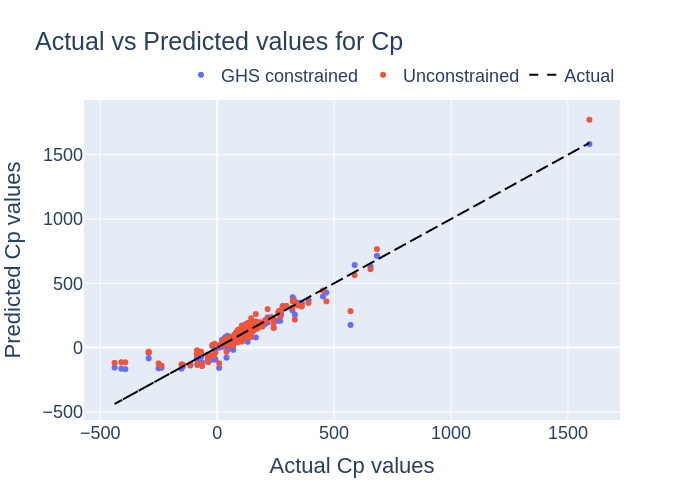

In [64]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp predicted"],
    name='GHS constrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp predicted (unconstrained)"],
    name='Unconstrained',
    mode='markers',
)

fig3 = go.Scatter(
    x=df_target_results["Cp expected"], 
    y=df_target_results["Cp expected"],
    name='Actual',
    mode='lines',
    line=dict(color="black", dash='dash'),
)

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    title="Actual vs Predicted values for Cp",
    xaxis_title="Actual Cp values",
    yaxis_title="Predicted Cp values",
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

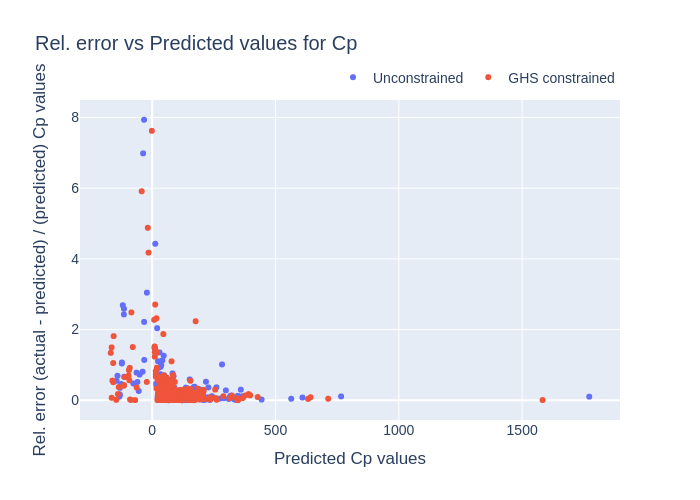

In [65]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_target_results["Cp predicted (unconstrained)"], 
    y=df_target_errors_unconstrained["Cp rel. error"],
    name='Unconstrained',
    mode='markers',
)

fig2 = go.Scatter(
    x=df_target_results["Cp predicted"], 
    y=df_target_errors["Cp rel. error"],
    name='GHS constrained',
    mode='markers',
)

fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Rel. error vs Predicted values for Cp",
    xaxis_title="Predicted Cp values",
    yaxis_title="Rel. error (actual - predicted) / (predicted) Cp values",
    font=dict(
        size=14,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

`Cp` residuals distribution:

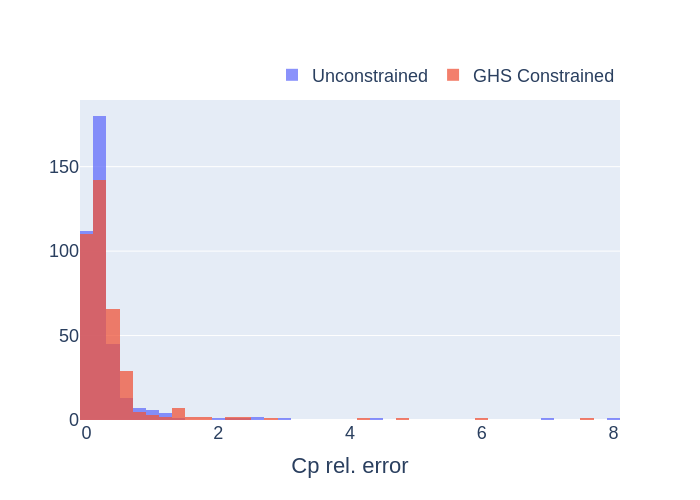

In [66]:
fig = go.Figure()

fig1 = go.Histogram(x=df_target_errors_unconstrained["Cp rel. error"], name='Unconstrained')
fig2 = go.Histogram(x=df_target_errors["Cp rel. error"], name='GHS Constrained')

fig.add_traces([fig1, fig2])

fig.update_layout(
    xaxis_title="Cp rel. error",
    barmode='overlay',
    font=dict(
        size=18,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)
fig.update_traces(opacity=0.75)

fig.show()

### Verifying the consistency of the predicted values

To evaluate the quality of the predictions from a thermodynamic point of view, we should assess the GHS residual to check if the predictions are consistent.

* Thermodynamically constrained:

In [67]:
df_predicted_species = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict.columns):
    df_predicted_species.loc[:, target] = df_y_predict.loc[:, target].values
    
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,-116.072151,-61.856926,294.594238,84.070709
1155,CaO·Al2O3,158.0406,508.3560,-1893.109619,-1778.153076,111.800858,111.881226
389,SiN,42.0927,114.6350,-3.573109,-30.530701,205.991470,55.745239
590,Cu2O,143.0794,168.8690,-301.313629,-274.102448,69.547508,62.962341
975,UO2,270.0278,255.3480,-678.035217,-694.784180,317.276550,47.635956
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-655.465515,-626.321655,282.259949,65.409851
1130,CaSO4·0.5H2O,145.1493,716.7490,-3146.597656,-2991.389404,181.451584,184.790710
162,P,30.9738,41.0900,20.733070,19.053005,36.969147,10.663681
1352,NaOCH3,54.0244,355.5450,-352.068512,-272.515839,82.550377,90.530243


* Thermodynamically unconstrained:

In [68]:
df_predicted_species_unconstrained = df_nist_stdprops.loc[X_test_rescaled.index, ["Formula", "Molar Mass", "Se"]]
for target in list(df_y_predict_unconstrained.columns):
    df_predicted_species_unconstrained.loc[:, target] = df_y_predict_unconstrained.loc[:, target].values
    
df_predicted_species_unconstrained

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp
585,Hg(CH3)2,230.6604,479.5520,-214.490738,-173.548828,353.666931,97.001732
1155,CaO·Al2O3,158.0406,508.3560,-2150.242188,-2026.942261,105.790421,126.055244
389,SiN,42.0927,114.6350,60.007366,32.711582,192.130127,39.369461
590,Cu2O,143.0794,168.8690,-4.538205,-16.379818,109.347015,40.376534
975,UO2,270.0278,255.3480,-385.856384,-380.148285,297.195435,63.518761
...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-759.983398,-728.113586,284.163391,72.047218
1130,CaSO4·0.5H2O,145.1493,716.7490,-2607.422119,-2466.494141,152.568420,148.846359
162,P,30.9738,41.0900,83.366905,79.397713,24.799210,23.670610
1352,NaOCH3,54.0244,355.5450,-271.408478,-240.885284,74.114746,58.293617


Collecting the GHS residuals:

In [69]:
T = 298.15  # in K
predicted_GHS_residuals = []
predicted_GHS_residuals_unconstrained = []
expected_GHS_residuals = []
df_expected_stdprops = df_nist_stdprops.loc[X_test_rescaled.index, :]
for index, row in df_predicted_species.iterrows():
    # Skorch
    G0_predicted = row["deltaG0"] * 1000
    H0_predicted = row["deltaH0"] * 1000
    S0_predicted = row["S0"]
    Se_predicted = row["Se"]
    GHS_residual_predicted = G0_predicted - H0_predicted + T * (S0_predicted - Se_predicted)
    predicted_GHS_residuals.append(GHS_residual_predicted)
    
    # Sklearn
    G0_unconstrained = df_predicted_species_unconstrained.loc[index, "deltaG0"] * 1000
    H0_unconstrained = df_predicted_species_unconstrained.loc[index, "deltaH0"] * 1000
    S0_unconstrained = df_predicted_species_unconstrained.loc[index, "S0"]
    Se_unconstrained = df_predicted_species_unconstrained.loc[index, "Se"]
    GHS_residual_predicted_unconstrained = G0_unconstrained - H0_unconstrained + T * (S0_unconstrained - Se_unconstrained)
    predicted_GHS_residuals_unconstrained.append(GHS_residual_predicted_unconstrained)
    
    G0_expected = df_expected_stdprops.loc[index, "deltaG0"] * 1000
    H0_expected = df_expected_stdprops.loc[index, "deltaH0"] * 1000
    S0_expected = df_expected_stdprops.loc[index, "S0"]
    Se_expected = df_expected_stdprops.loc[index, "Se"]
    GHS_residual_expected = G0_expected - H0_expected + T * (S0_expected - Se_expected)
    expected_GHS_residuals.append(GHS_residual_expected)
    
df_predicted_species["GHS residual"] = predicted_GHS_residuals
df_predicted_species_unconstrained["GHS residual"] = predicted_GHS_residuals_unconstrained
df_expected_stdprops["GHS residual"] = expected_GHS_residuals
df_predicted_species

,Formula,Molar Mass,Se,deltaH0,deltaG0,S0,Cp,GHS residual
585,Hg(CH3)2,230.6604,479.5520,-116.072151,-61.856926,294.594238,84.070709,-929.931437
1155,CaO·Al2O3,158.0406,508.3560,-1893.109619,-1778.153076,111.800858,111.881226,-3276.372755
389,SiN,42.0927,114.6350,-3.573109,-30.530701,205.991470,55.745239,280.340097
590,Cu2O,143.0794,168.8690,-301.313629,-274.102448,69.547508,62.962341,-2401.521128
975,UO2,270.0278,255.3480,-678.035217,-694.784180,317.276550,47.635956,1715.034868
...,...,...,...,...,...,...,...,...
55,BrF3,136.9042,380.2855,-655.465515,-626.321655,282.259949,65.409851,-82.458248
1130,CaSO4·0.5H2O,145.1493,716.7490,-3146.597656,-2991.389404,181.451584,184.790710,-4390.672668
162,P,30.9738,41.0900,20.733070,19.053005,36.969147,10.663681,-2908.697558
1352,NaOCH3,54.0244,355.5450,-352.068512,-272.515839,82.550377,90.530243,-1840.673540


#### Visual verification

* Thermodynamically constrained:

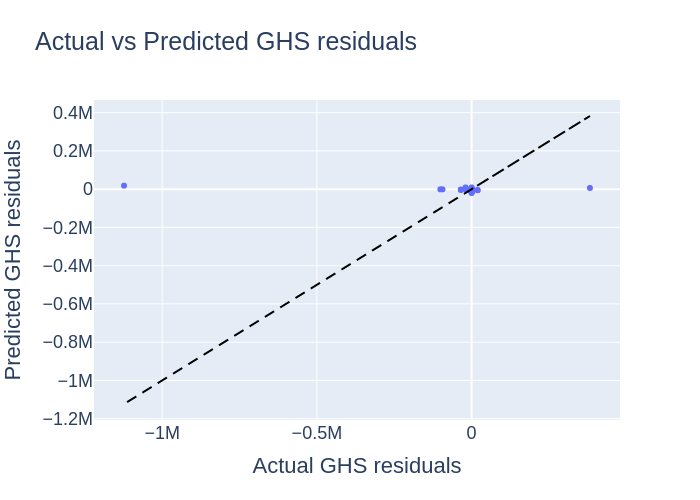

In [70]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* Thermodynamically unconstrained:

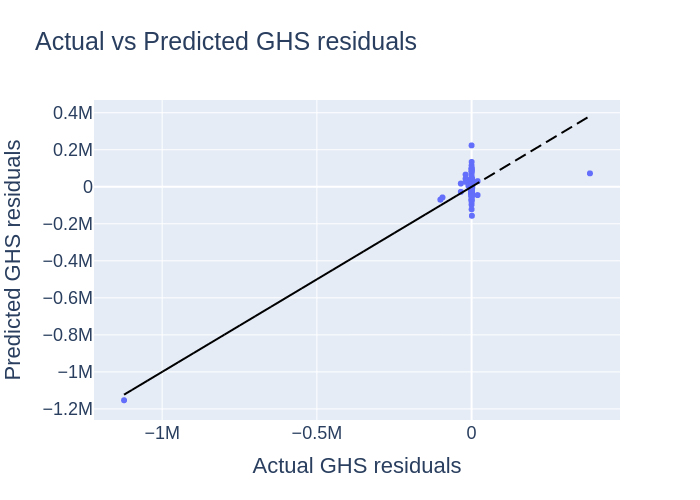

In [71]:
fig = go.Figure()

fig1 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_predicted_species_unconstrained["GHS residual"],
    mode='markers',
)

fig2 = go.Scatter(
    x=df_expected_stdprops["GHS residual"], 
    y=df_expected_stdprops["GHS residual"], 
    line=dict(color="black", dash='dash'),
    mode='lines',
)
fig.add_traces([fig1, fig2])

fig.update_layout(
    title="Actual vs Predicted GHS residuals",
    xaxis_title="Actual GHS residuals",
    yaxis_title="Predicted GHS residuals",
    showlegend=False,
    font=dict(
        size=18,
    )
)

fig.show()

* Consistent vs inconsistent:

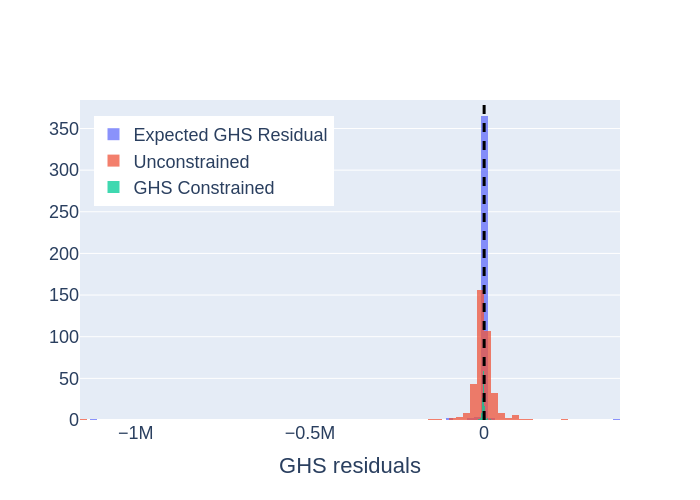

In [72]:
fig = go.Figure()

fig1 = go.Histogram(x=df_expected_stdprops["GHS residual"], name='Expected GHS Residual')
fig2 = go.Histogram(x=df_predicted_species_unconstrained["GHS residual"], name='Unconstrained')
fig3 = go.Histogram(x=df_predicted_species["GHS residual"], name='GHS Constrained')

fig.add_traces([fig1, fig2, fig3])

fig.update_layout(
    # title="GHS residuals",
    xaxis_title="GHS residuals",
    barmode='overlay',
    # yaxis_title="Predicted GHS residuals",
    # showlegend=False,
    font=dict(
        size=18,
    ),
    legend=dict(
        yanchor="top",
        xanchor="left",
        x=0.025,
        y=0.95,
    )
)
fig.update_traces(opacity=0.75)
fig.add_vline(x=0.0, line_width=3, line_dash="dash", line_color="black")

fig.show()